In [3]:
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import random

<h1>Pruebas de asignación de asientos</h1>

In [4]:
def color_map_calidades(G):
    calidades = [G.nodes[i]['calidad'] for i in G]
    max_calidades = max(calidades)
    colormap_calidades = [(1-i/max_calidades,i/max_calidades,0) for i in  calidades] 
    colormap_calidades = [list(i) for i in mpl.colors.to_rgba_array(colormap_calidades)]
    return(colormap_calidades)

In [5]:
def convertTuple(tup):
    s = tuple(str(x) for x in tup)
    return(','.join(s))

In [6]:
G = nx.grid_2d_graph(5, 5)  # 5x5 grid
# grid_2d_graph nombra los nodos con tuples de int. Yo lo paso a string
G = nx.relabel_nodes(G, lambda x: convertTuple(x), copy = True)
# luego les doy pesos aleatorios a los edges (distancias entre nodos o asientos)
for i in G:
    for j in G[i]:
        G[i][j]["weight"] = 1/random.randint(1,20)
        

<h3>Se entiende que si el resultado de random.randint es la distancia entre dos asientos,
para los pesos cojemos el inverso de esa distancia (para que más sea mejor) </h3>

C:\Users\malcubierre\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


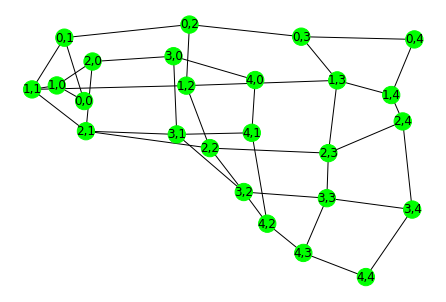

In [7]:
for nodo in G:
    nx.set_node_attributes(G, {nodo : {'calidad' : 1}})
nx.draw_spring(G, with_labels = True , node_color = color_map_calidades(G))
#nx.draw_networkx_labels(G, nx.spring_layout(G), labels=None, font_size=12, font_color='b')
plt.show()

#### -los numeros con coma que se ven aqui son tan solo los nombres de los nodos generados aleatoriamente.

In [8]:
# luego fusionando asientos obtendre parejas de asientos, luego con estos nodos de parejas buscare trios...

# de este modo luego tengo una lista de parejas, otra de trios... donde ir metiendo a la gente segun llegue
# y segun con cuanta gente se quieran sentar juntos

# aunque esto de fusionar nodos así de 2 en 2 no lo veo de todo, 
# porque puede ser que 3 nodos hagan el mejor trio 
# sin que cogidos sus  elementos de 2 en 2 formen parte de las mejores parejas ...
# pero partiré de esto que es lo que ellos hacen.
# para hacer otra cosa habría que usar otro algoritmo, no el "max_weight_matching"

In [9]:
# aqui incorporo una cosa que les falta a ellos para que les de cosas razonables
# en concreto, mi max(wea,web) donde ellos hacen un sum, -add new edge with same weight + weight of the pair-.
# Osea:
# no veo que ellos tengan en cuenta que si "a" esta cerca de "b" y "b" esta cerca de "c", 
# la distancia entre el nodo fusionado "ab" y "c" 
# es igual a la distancia de "b" a "c", y que la distancia de "a" a "c" ya no importa (por sentido común)
def pesos_edges_nodo_fusionado(edge):
    a = {i:G[edge[0]][i]["weight"] for i in G[edge[0]]}
    b = {i:G[edge[1]][i]["weight"] for i in G[edge[1]]}
    ab_adges = set()
    for e in a.keys():
        ab_adges.add(e)
    for e in b.keys():
        ab_adges.add(e)
    ab_edges_weights = {}
    for e in ab_adges:
        try:
            wea = a[e]
        except:
            wea = 0
        try:
            web = b[e]
        except:
            web = 0
        ab_edges_weights[e] = max(wea,web) # aqui la mejora
        ab_edges_weights.pop(edge[0], None)
        ab_edges_weights.pop(edge[1], None)       
    return(ab_edges_weights)

In [10]:
def hacer_cluster(G, max_size_cluster = 2):  #(esto es fusionar nodos)
    Gr = G
    clusters = nx.max_weight_matching(Gr,maxcardinality=True)
    for pair in clusters:
        if len(pair[0].split("-")) + len(pair[1].split("-")) > max_size_cluster:
            continue
        nuevo_nodo = pair[0] + ' - ' + pair[1]
        Gr.add_node(nuevo_nodo)
        
        # y aqui tambien hay otra cosa que ellos no tienen: puntuar los clusters de nodos
        # la puntuacion de un cluster es el peso que existia entre sus componentes, antes de fusionarlos
        
        # asi luego si me llega una pareja podré darles la pareja de asientos en la que más
        # cerca van a estar
        
        nx.set_node_attributes(Gr, {nuevo_nodo : {'calidad' : Gr[pair[0]][pair[1]]['weight']}})
        relaciones = pesos_edges_nodo_fusionado(pair)
        for nodo_edge in relaciones.keys():
            Gr.add_edge(nuevo_nodo, nodo_edge, weight = relaciones[nodo_edge])
    for pair in clusters:
        if len(pair[0].split("-")) + len(pair[1].split("-")) > max_size_cluster:
            continue
        Gr.remove_node(pair[0])
        Gr.remove_node(pair[1])
    nx.draw_spring(Gr, with_labels = True, node_color = color_map_calidades(Gr))
    plt.show()
    return(Gr)

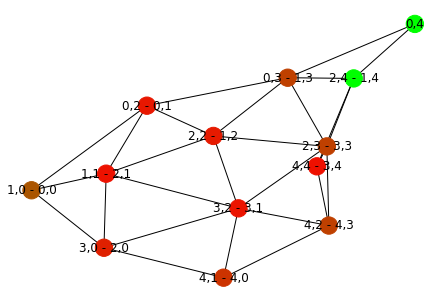

In [11]:
g2 = hacer_cluster(G)

#### -Aqui tengo separados por guion los nombres de los nodos (asientos) originales que se han fusionado
#### -Los colores representan la puntuacion de los clusters. Verde bien, rojo mal

In [12]:
# vale pero aqui ya vi que pasan cosas poco deseables a veces. Por ejemplo. Veo un nodo llamado 1.1 que estaba 
# muy cerca de muchos otros nodos, y sin embargo el max_weight_matching no lo emparejo con ninguno (emparejo todos
# los demas pero ese justamente es el que dejo suelto al haber un numero impar de ellos)
# yo supongo que es porque el algoritmo vio que en ese caso si emparejase ese nodo con alguno de los demas, 
# su pareja no podria emparejarse con un tercero, que al dejar libre a un cuarto, en conjunto 
# daria menos puntuacion... o algo así.
# Pero esto no es lo que queremos. Porque al final no todos los asientos libres los van a ocupar parejas.
# Osea el algoritmo max_weight_matching no busca las mejores parejas necesariamente. Busca la mejor forma de 
# emparejarlo TODO

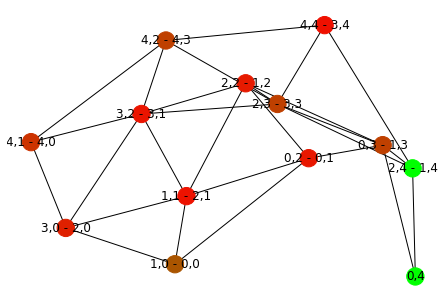

In [13]:
g3 = hacer_cluster(G,max_size_cluster = 3)

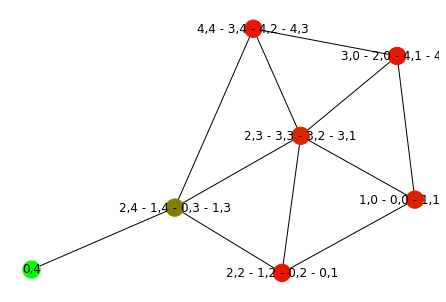

In [14]:
g4 = hacer_cluster(G,max_size_cluster = 4)